<a href="https://colab.research.google.com/github/Luqy12099/CNN_yoga_poses/blob/master/CNN_yoga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import numpy as np
import os
import shutil
!pip install -q kaggle

# Data collect

## Connect to kaggle
Before running the code, make sure to create new API token from kaggle. Then upload it

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d ujjwalchowdhury/yoga-pose-classification

100% 15.0M/15.0M [00:00<00:00, 24.9MB/s]
100% 15.0M/15.0M [00:00<00:00, 16.1MB/s]


## Data Exploring

In [6]:
!unzip '/content/yoga-pose-classification.zip' -d "/content"
from google.colab import output
output.clear()

In [7]:
source = '/content/YogaPoses' #Directory dataset
classes = ['Downdog','Goddess','Plank','Tree','Warrior2']

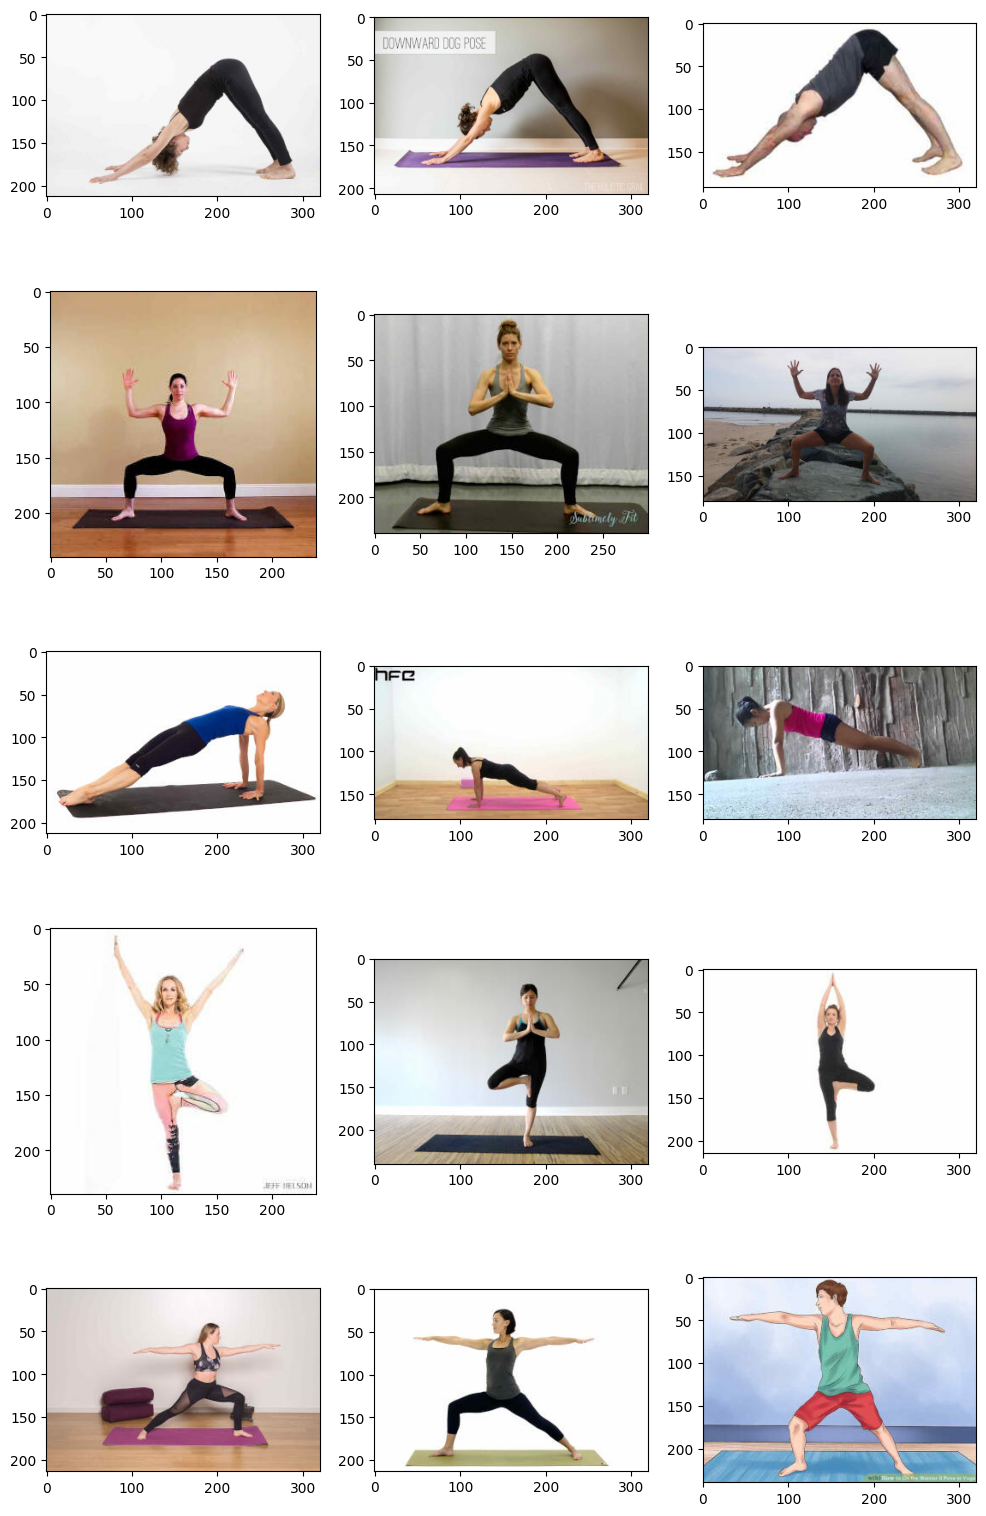

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Set number of columns and rows
nrows = 5; ncols = 3

# Set matplotlib and its size
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index = 3; full_path = []
for categori in classes:
    categori_dir = os.listdir(source + '/' + categori)
    categori_path = [os.path.join(source + '/' + categori, fname)
                                 for fname in categori_dir[0:pic_index]]
    full_path.append(categori_path)

i=1
for img_path in full_path:
  for path in img_path:
      sp = plt.subplot(nrows, ncols, i)
      i += 1
      sp.axis('On') # Appear dimension of images
      img = mpimg.imread(path)
      plt.imshow(img)
plt.show()

# Data preprocessing

In [9]:
source = '/content/YogaPoses'#letak filenya
classes = ['Downdog','Goddess','Plank','Tree','Warrior2']

In [10]:
train_ratio = 0.8
for i in classes:
    os.makedirs(source + 'Output/train/' + i)
    os.makedirs(source + 'Output/valid/' + i)
    source_1_yoga = source + '/' + i
    allFileNames = os.listdir(source_1_yoga) # add all name file into list
    np.random.shuffle(allFileNames) # Make it random

    #Split train and validation file
    train_FileNames, valid_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)*(train_ratio))])
    train_FileNames = [source + '/' + i + '/' + name for name in train_FileNames.tolist()]
    valid_FileNames = [source + '/' + i + '/' + name for name in valid_FileNames.tolist()]
    print(len(train_FileNames))
    print(len(valid_FileNames))

    #Copy dataset into another folder output with sub directory train and valid
    for name in train_FileNames:
      shutil.copy(name, source + 'Output/train/' + i)
    for name in valid_FileNames:
      shutil.copy(name, source + 'Output/valid/' + i)

156
40
159
40
157
40
158
40
158
40


In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#proses scaling data sehingga pixel antara 0 - 1
train_datagen = ImageDataGenerator(rescale = 1/255)
valid_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
    source + 'Output/train/',
    classes = classes,
    target_size =(200, 200),
    batch_size = 16,#semakin kecil semakin bagus dan semakin lama
    class_mode = 'categorical')

valid_generator = valid_datagen.flow_from_directory(
    source + 'Output/valid/',
    classes = classes,
    target_size = (200, 200),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = False)

Found 788 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


# Build model

In [78]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [80]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2),
                                                           activation='relu', padding = 'same',
                                                           input_shape = (200, 200, 3),
                                                           kernel_initializer='he_normal',
                                                           bias_initializer='zeros'),
                                    tf.keras.layers.MaxPool2D(pool_size = (2,2) ),
                                    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2),
                                                           activation='relu', padding = 'same',
                                                           kernel_initializer='he_normal',
                                                           bias_initializer='zeros'),
                                    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(5, activation=tf.nn.softmax)])

In [81]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 50, 50, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 12, 12, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 9216)              0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [82]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [83]:
%%time
history = model.fit(train_generator,
      steps_per_epoch=48,
      epochs=8,
      verbose=1,
      validation_data = valid_generator,
      validation_steps=12)

Epoch 1/8
48/48 [==============================] - 3s 37ms/step - loss: 1.8578 - accuracy: 0.4153 - val_loss: 0.9546 - val_accuracy: 0.6823
Epoch 2/8
48/48 [==============================] - 2s 40ms/step - loss: 0.7573 - accuracy: 0.7422 - val_loss: 0.7044 - val_accuracy: 0.7865
Epoch 3/8
48/48 [==============================] - 2s 47ms/step - loss: 0.4127 - accuracy: 0.8585 - val_loss: 0.5486 - val_accuracy: 0.7969
Epoch 4/8
48/48 [==============================] - 2s 31ms/step - loss: 0.2291 - accuracy: 0.9325 - val_loss: 0.6759 - val_accuracy: 0.7812
Epoch 5/8
48/48 [==============================] - 2s 33ms/step - loss: 0.1548 - accuracy: 0.9603 - val_loss: 0.5051 - val_accuracy: 0.8281
Epoch 6/8
48/48 [==============================] - 2s 34ms/step - loss: 0.0875 - accuracy: 0.9854 - val_loss: 0.5836 - val_accuracy: 0.8281
Epoch 7/8
48/48 [==============================] - 2s 39ms/step - loss: 0.0498 - accuracy: 0.9921 - val_loss: 0.6447 - val_accuracy: 0.8438
Epoch 8/8
48/48 [===

In [84]:
model.evaluate(valid_generator)

13/13 [==============================] - 0s 22ms/step - loss: 0.5897 - accuracy: 0.8450


[0.5896797776222229, 0.8450000286102295]

# Deployment

Saving plank 2.jpg to plank 2 (1).jpg
1/1 [==============================] - 0s 59ms/step
[0. 0. 1. 0. 0.]
hasil prediksi dari gambar yang diinput adalah Plank


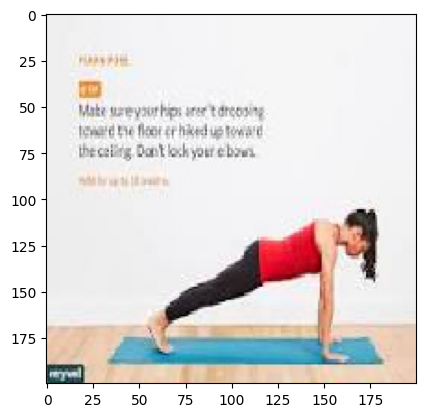

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # prdiksi
  path = '/content/' + fn
  img = image.load_img(path, target_size=(200, 200))
  x = image.img_to_array(img)
  plt.imshow(x/255.)#scaling
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])

  classes = classes[0].tolist()
  max_value = max(classes)
  max_index = classes.index(max_value)
  classes = ['Downdog','Goddess','Plank','Tree','Warrior2']
  print('hasil prediksi dari gambar yang diinput adalah', classes[max_index])